# Task 7: Root System Architecture (RSA) Extraction

The goal of this task is to extract the RSA from each root mask, in order to classify root types (primary vs. secondary) and to find the root tips. The final step in this task is to measure the primary root length, and locate the primary root tip coordinatees.

In [3]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skan import Skeleton, summarize, draw
from skan.csr import skeleton_to_csgraph
import networkx as nx

## Step 1: Load mask

This initial step prepares the image for analysis. First, the code loads the root mask file in grayscale using the OpenCV library. It immediately binarizes this image, creating a stark black-and-white version where all root pixels are white and the background is black. To clean up any potential noise or stray pixels, it then identifies all disconnected white objects and keeps only the single largest component, which is assumed to be the main root system. Finally, the `skeletonize` function is used to thin this primary shape into a one-pixel-thick skeleton, simplifying the complex root structure into its essential lines for the next stage of analysis.

In [4]:
# Load root mask
mask_path = r"C:\BUAS\retake\2024-25b-fai2-adsai-dariavladutu236578\datalab_tasks\task6\components\plant_1.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
binary_mask = (mask > 0).astype(np.uint8)

# Find connected components (root parts)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

# Select the largest component (root)
largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
component_mask = (labels == largest_component).astype(np.uint8)

# Skeletonize the mask
skeleton = skeletonize(component_mask)

## Step 2: Build skeleton graph

After creating the skeleton, we convert the pixel-based image into a mathematical graph, which is an abstract structure of nodes and connections. Using the `skan` and `networkx` libraries, it analyzes the skeleton to identify all the nodes (which represent root tips and junctions) and the edges (which represent the root branches connecting those nodes). This process also calculates the pixel length of each branch, storing it as a key attribute (branch-distance) within the graph. The result is a fully digital representation of the root's architecture.

In [5]:
# Create graph from skeleton
g0, c0 = skeleton_to_csgraph(skeleton)
node_coordinates = np.transpose(c0)
skeleton_obj = Skeleton(skeleton)
branch_data = summarize(skeleton_obj)

# Build graph from branch data
G = nx.from_pandas_edgelist(branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

C:\Users\dari\AppData\Local\Temp\ipykernel_21324\1351314945.py:5: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skeleton_obj)


## Step 3: Find tip nodes 

The algorithm operates on the assumption that the main, primary root will begin and end at a tip of the overall root system. In the context of the graph, a tip is a node that has a "degree" of 1, meaning it is an endpoint with only one branch connected to it. The code efficiently identifies all these endpoints with a single line that filters through every node in the graph, creating a list of all nodes that meet this specific criterion.

In [6]:
# Identify all tip nodes (degree = 1)
tip_nodes = [node for node, degree in G.degree() if degree == 1]

## Step 4: Trace tip-to-tip path

To find the most likely primary root, we must systematically evaluate all major pathways through the root system. We achieve this by tracing the paths between the tip nodes identified in the previous step. For each tip node, I used Dijkstra's algorithm, a classic and highly efficient method for finding the shortest path from a single starting point to all other nodes in a weighted graph. By running this process from every tip, the code effectively analyzes every possible tip-to-tip route, ensuring a comprehensive search.

## Step 5: Score paths based on heuristics

Simply finding the longest path is not reliable, as a meandering lateral root could be longer than the primary one. Therefore, the code uses a more intelligent approach by calculating a custom score for each path based on a set of heuristics that define an ideal primary root. The score is calculated using the formula score=vertical_ratio×length×(1−center_penalty). This formula gives the highest scores to paths that are simultaneously long, predominantly vertical in their growth direction, and centrally located within the image.

## Step 6: Select the best path as primary root

The script determines the final primary root path by carrying out a simple comparison. It initializes a `best_score` variable to zero and then loops through all the paths it traced. For each path, it calculates the heuristic score, and if that score is higher than the current `best_score`, the script updates the `best_score` and designates the current path as the new candidate for the primary root. After every path has been scored and compared, the one that achieved the highest score is officially selected as the primary root.

In [7]:
longest_path = []
best_score = 0

height, width = skeleton.shape
image_center_x = width / 2

for tip in tip_nodes:
    lengths, paths = nx.single_source_dijkstra(G, tip, weight='branch-distance')
    for target, length in lengths.items():
        path = paths[target]
        if len(path) < 2:
            continue

        # Get vertical displacement (Y axis)
        y_start = node_coordinates[path[0]][0]
        y_end = node_coordinates[path[-1]][0]
        delta_y = abs(y_end - y_start)

        # Get horizontal midline distance
        x_coords = [node_coordinates[n][1] for n in path]
        avg_x = np.mean(x_coords)
        x_dist_from_center = abs(avg_x - image_center_x)

        # Compute verticality score
        vertical_ratio = delta_y / (length + 1e-6)  # avoid divide-by-zero
        center_penalty = x_dist_from_center / width  # normalized

        # Final score: favor long + vertical + centered paths
        score = vertical_ratio * length * (1 - center_penalty)

        if score > best_score:
            best_score = score
            longest_path = path
            best_length = length

## Step 7: Branch classification

Once the primary root path is identified, the code proceeds to classify every single branch in the entire root system. It first creates a definitive list of all the edges (the connections between nodes) that make up the selected primary root. It then iterates through all branches in its dataset, assigning each one a branch-type. If a branch is part of the primary root list, it is classified as primary (type 1); otherwise, it is classified as a lateral root (type 2).

In [8]:
# Classify the root branches based on the longest path
# Label branches as primary (1) or lateral (2)
primary_root_edges = set(zip(longest_path[:-1], longest_path[1:]))
branch_data['branch-type'] = branch_data.apply(
    lambda row: 1 if (row['node-id-src'], row['node-id-dst']) in primary_root_edges or
                     (row['node-id-dst'], row['node-id-src']) in primary_root_edges else 2,
    axis=1
)

## Step 8: Visualisation

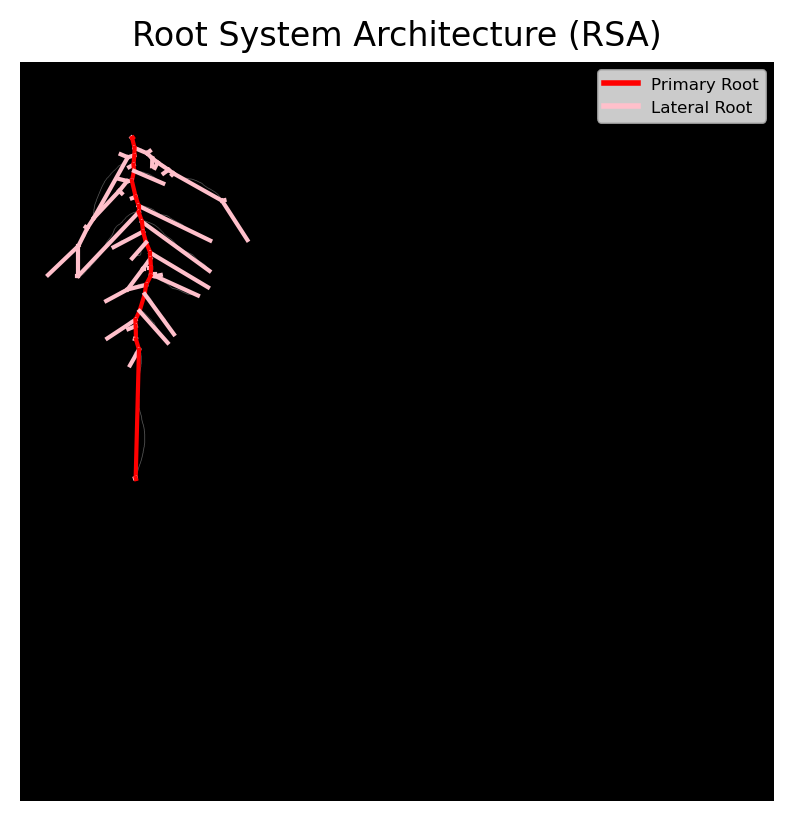

Primary root length: 1368.35 pixels
Primary root path: [1, 5, 41, 153, 330, 459, 763, 1081, 1238, 1397, 1654, 1939, 2293, 2558, 2749, 3028, 3275, 3498, 3719, 3932, 4042, 4149, 4371, 4425, 4959, 4964]


In [13]:
# Visualize the RSA with color-coded branches
branch_colors = {1: 'red', 2: 'pink'}  # Red for primary, blue for lateral

fig, ax = plt.subplots()
ax.imshow(skeleton, cmap='gray')

# Draw each branch with its corresponding color
for _, row in branch_data.iterrows():
    src = int(row['node-id-src'])
    dst = int(row['node-id-dst'])
    color = branch_colors[row['branch-type']]
    
    # Get coordinates of source and destination nodes
    p1 = node_coordinates[src]
    p2 = node_coordinates[dst]
    
    # Plot line segment
    ax.plot([p1[1], p2[1]], [p1[0], p2[0]], color=color, lw=1.5)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Primary Root'),
    Line2D([0], [0], color='pink', lw=2, label='Lateral Root')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=6, frameon=True)

ax.set_title("Root System Architecture (RSA)")
ax.axis('off')
fig.set_dpi(200)
plt.show()

# Print Results
print(f"Primary root length: {best_length:.2f} pixels")
print(f"Primary root path: {longest_path}")

## All plants from task 6

C:\Users\dari\AppData\Local\Temp\ipykernel_21324\1702465934.py:45: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skeleton_obj)


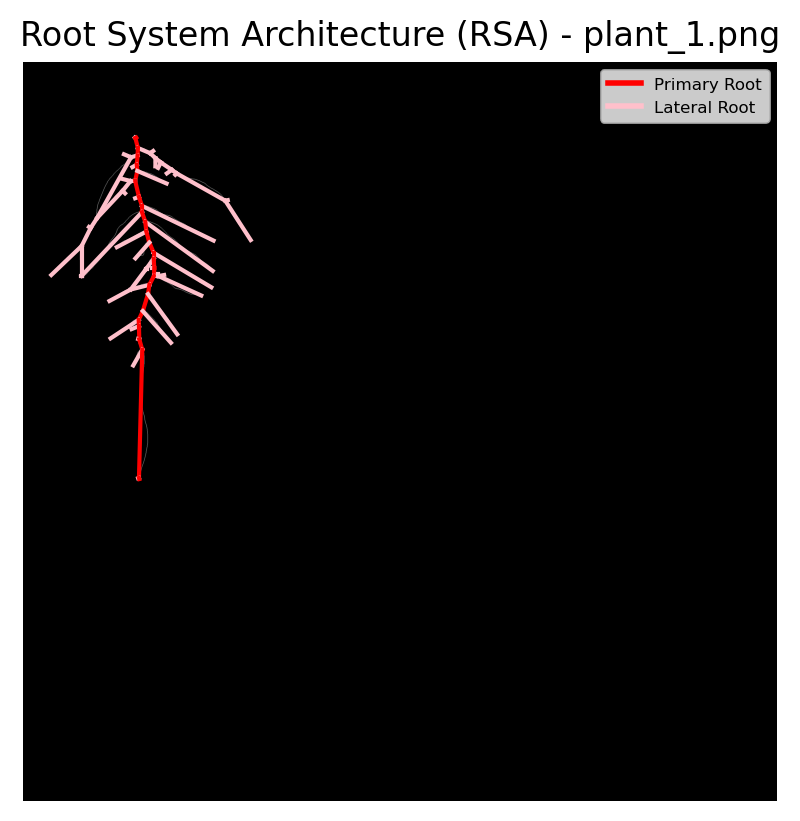

plant_1.png: Primary root length = 1368.35 pixels
Primary root path: [1, 5, 41, 153, 330, 459, 763, 1081, 1238, 1397, 1654, 1939, 2293, 2558, 2749, 3028, 3275, 3498, 3719, 3932, 4042, 4149, 4371, 4425, 4959, 4964]


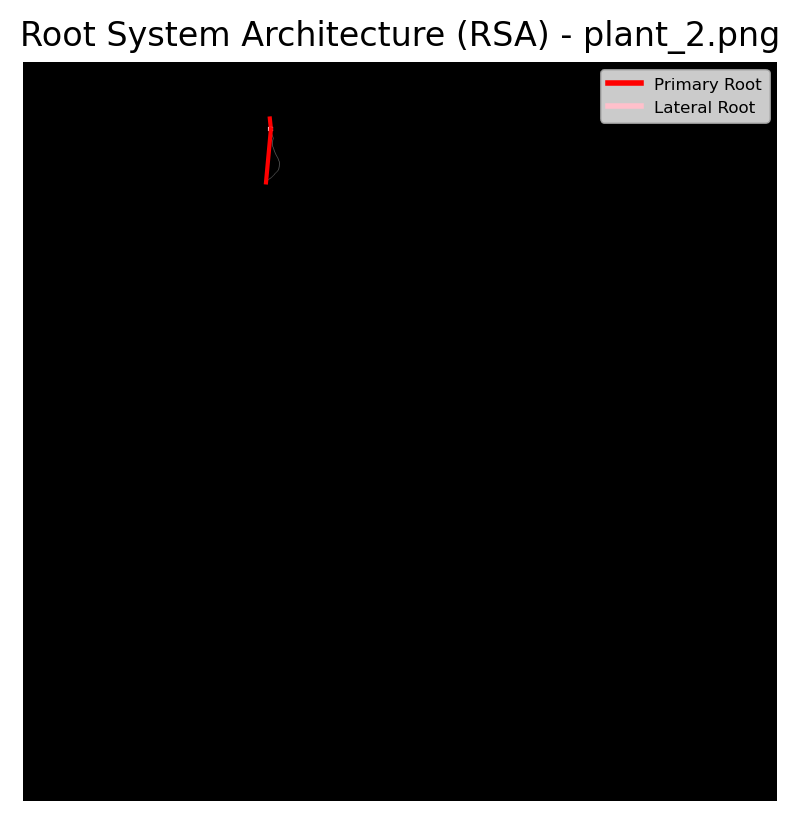

plant_2.png: Primary root length = 275.87 pixels
Primary root path: [0, 42, 242]
Failed to process plant_3.png: attempt to get argmax of an empty sequence


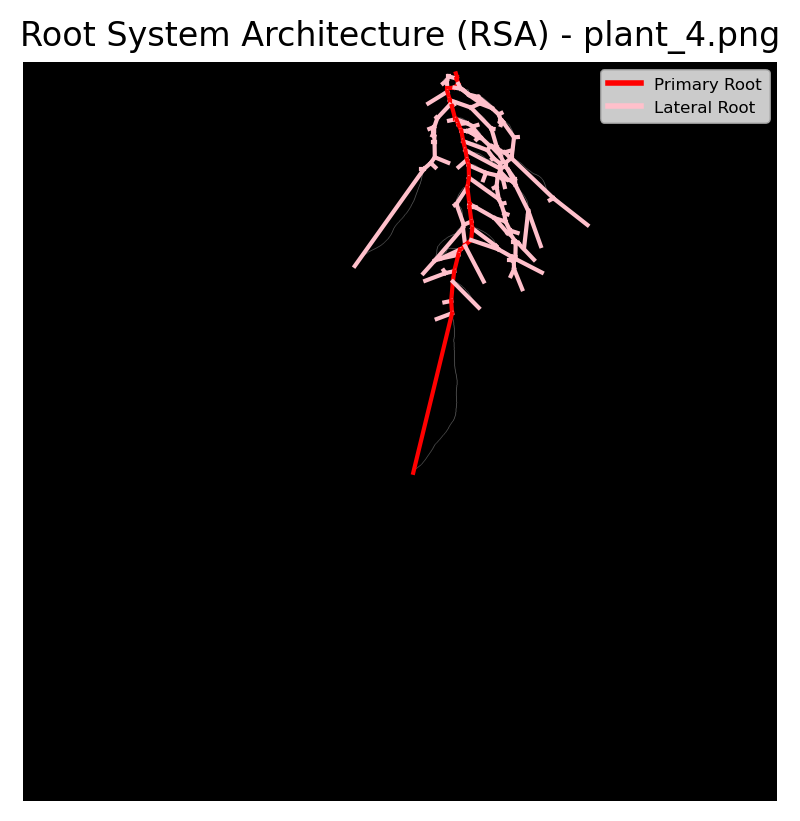

plant_4.png: Primary root length = 1672.23 pixels
Primary root path: [0, 36, 62, 123, 171, 196, 272, 480, 634, 688, 992, 996, 1183, 1395, 1691, 1999, 2371, 2623, 3141, 3503, 3987, 4075, 4611, 4840, 5308, 5555, 5597, 5794, 6012, 6566, 6817, 7009, 7106, 7744]


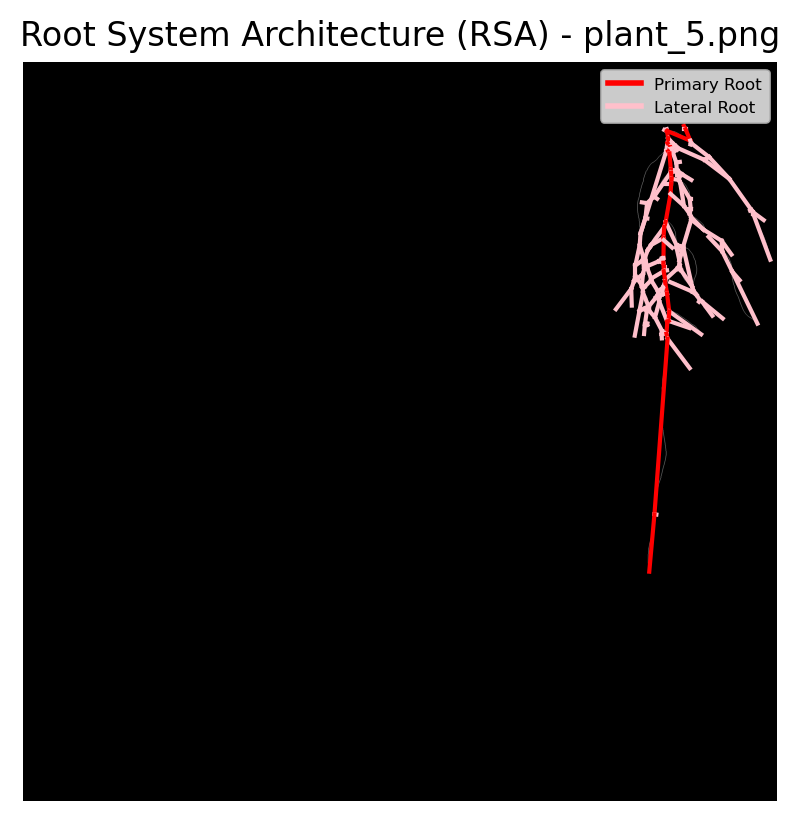

plant_5.png: Primary root length = 1886.58 pixels
Primary root path: [0, 18, 209, 41, 48, 154, 235, 326, 381, 453, 510, 919, 1010, 1012, 1230, 1399, 1617, 2401, 2564, 2928, 3005, 3798, 4014, 4161, 4329, 4348, 4714, 4806, 5314, 6062, 6422, 6458, 6795, 6847, 7601, 7818]


In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skan import Skeleton, summarize, draw
from skan.csr import skeleton_to_csgraph
import networkx as nx
from matplotlib.lines import Line2D

# Input and output directories
input_dir = r"C:\BUAS\retake\2024-25b-fai2-adsai-dariavladutu236578\datalab_tasks\task6\components"
output_dir = r"C:\BUAS\retake\2024-25b-fai2-adsai-dariavladutu236578\datalab_tasks\task7\RSA_output"
os.makedirs(output_dir, exist_ok=True)

# Loop through all PNG mask images
for filename in os.listdir(input_dir):
    if not filename.lower().endswith('.png'):
        continue

    mask_path = os.path.join(input_dir, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Skipping file (not readable): {filename}")
        continue

    try:
        # Load root mask
        binary_mask = (mask > 0).astype(np.uint8)

        # Find connected components (root parts)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

        # Select the largest component (root)
        largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        component_mask = (labels == largest_component).astype(np.uint8)

        # Skeletonize the mask
        skeleton = skeletonize(component_mask)

        # Create graph from skeleton
        g0, c0 = skeleton_to_csgraph(skeleton)
        node_coordinates = np.transpose(c0)
        skeleton_obj = Skeleton(skeleton)
        branch_data = summarize(skeleton_obj)

        # Build graph from branch data
        G = nx.from_pandas_edgelist(branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

        # Identify all tip nodes (degree = 1)
        tip_nodes = [node for node, degree in G.degree() if degree == 1]

        # Find the longest path using Dijkstra's algorithm from each tip node
        longest_path = []
        best_score = 0
        best_length = 0

        height, width = skeleton.shape
        image_center_x = width / 2

        for tip in tip_nodes:
            lengths, paths = nx.single_source_dijkstra(G, tip, weight='branch-distance')
            for target, length in lengths.items():
                path = paths[target]
                if len(path) < 2:
                    continue

                # Get vertical displacement (Y axis)
                y_start = node_coordinates[path[0]][0]
                y_end = node_coordinates[path[-1]][0]
                delta_y = abs(y_end - y_start)

                # Get horizontal midline distance
                x_coords = [node_coordinates[n][1] for n in path]
                avg_x = np.mean(x_coords)
                x_dist_from_center = abs(avg_x - image_center_x)

                # Compute verticality score
                vertical_ratio = delta_y / (length + 1e-6)  # avoid divide-by-zero
                center_penalty = x_dist_from_center / width  # normalized

                # Final score: favor long + vertical + centered paths
                score = vertical_ratio * length * (1 - center_penalty)

                if score > best_score:
                    best_score = score
                    longest_path = path
                    best_length = length

        # Classify the root branches based on the longest path
        # Label branches as primary (1) or lateral (2)
        primary_root_edges = set(zip(longest_path[:-1], longest_path[1:]))
        branch_data['branch-type'] = branch_data.apply(
            lambda row: 1 if (row['node-id-src'], row['node-id-dst']) in primary_root_edges or
                             (row['node-id-dst'], row['node-id-src']) in primary_root_edges else 2,
            axis=1
        )

        # Visualize the RSA with color-coded branches
        branch_colors = {1: 'red', 2: 'pink'}

        fig, ax = plt.subplots()
        ax.imshow(skeleton, cmap='gray')

        # Draw each branch with its corresponding color
        for _, row in branch_data.iterrows():
            src = int(row['node-id-src'])
            dst = int(row['node-id-dst'])
            color = branch_colors[row['branch-type']]
            p1 = node_coordinates[src]
            p2 = node_coordinates[dst]
            ax.plot([p1[1], p2[1]], [p1[0], p2[0]], color=color, lw=1.5)

        # Add legend
        legend_elements = [
            Line2D([0], [0], color='red', lw=2, label='Primary Root'),
            Line2D([0], [0], color='pink', lw=2, label='Lateral Root')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=6, frameon=True)

        ax.set_title(f"Root System Architecture (RSA) - {filename}")
        ax.axis('off')
        fig.set_dpi(200)

        # Show plot
        plt.show()

        # Save visualization
        output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_rsa.png")
        fig.savefig(output_path, bbox_inches='tight')
        plt.close(fig)

        # Print Results
        print(f"{filename}: Primary root length = {best_length:.2f} pixels")
        print(f"Primary root path: {longest_path}")

    except Exception as e:
        print(f"Failed to process {filename}: {e}")

# Approach 2: Determining primary root based on topology

One shortcoming of the previous method is that sometimes lateral roots get mistaken as primary roots when they start from above the primary root. To potentially address this, I propose a solution based on the topology and hierarchy of the root system itself, rather that appearance in the image. The main logic is about the biological function of a primary root, defining it as the central scaffold supporting the most lateral branches. 

The core of the code lies in a dual-heuristic method for identifying the primary root. The script analyzes all possible main pathways by tracing the routes between every pair of root tips. For each path, it calculates two key metrics: its total length and the number of lateral branches connected to it. The final selection uses a robust fallback system: it prioritizes the path with the maximum number of lateral branches, based on the biological principle that the primary root is the main support structure. However, if no paths have any side branches—as is common with young seedlings—the algorithm intelligently defaults to selecting the longest path instead. Once the primary root is determined, all its branches are classified and colored red, with the remaining branches colored pink, before the final color-coded architectural map is displayed and saved to an output folder. 

C:\Users\dari\AppData\Local\Temp\ipykernel_21324\41422127.py:31: VisibleDeprecationWarning: separator in column name will change to _ in version 0.13; to silence this warning, use `separator='-'` to maintain current behavior and use `separator='_'` to switch to the new default behavior.
  branch_data = summarize(skeleton_obj)


Primary root for plant_1.png identified by MAX BRANCH COUNT (29 branches).


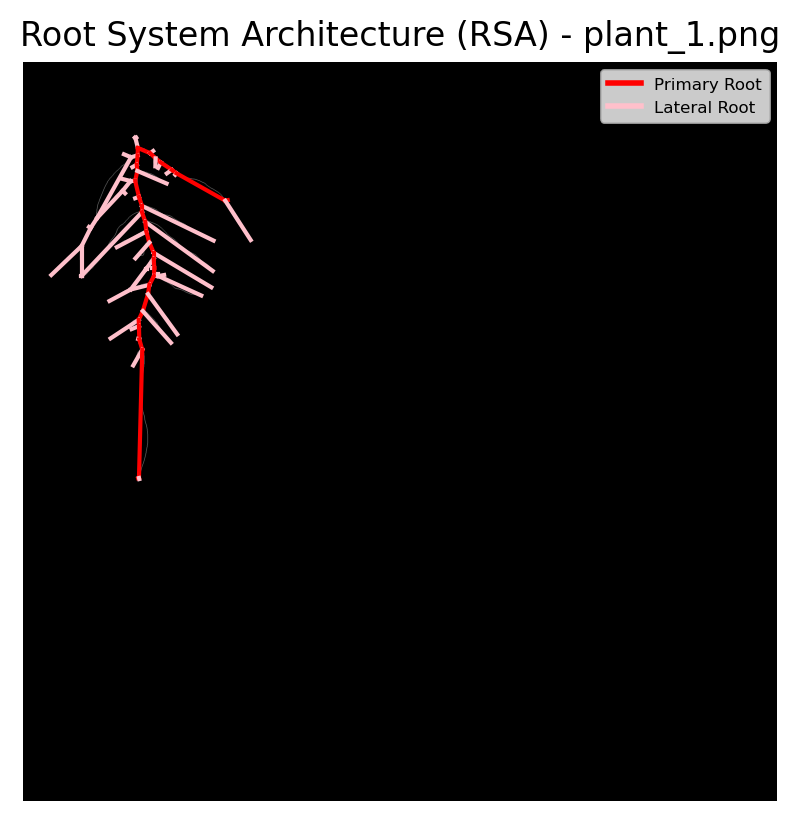

plant_1.png: Primary root length = 1744.45 pixels
Primary root path: [1152, 1162, 541, 436, 283, 216, 119, 41, 153, 330, 459, 763, 1081, 1238, 1397, 1654, 1939, 2293, 2558, 2749, 3028, 3275, 3498, 3719, 3932, 4042, 4149, 4371, 4425, 4959, 4960]

Primary root for plant_2.png identified by MAX BRANCH COUNT (1 branches).


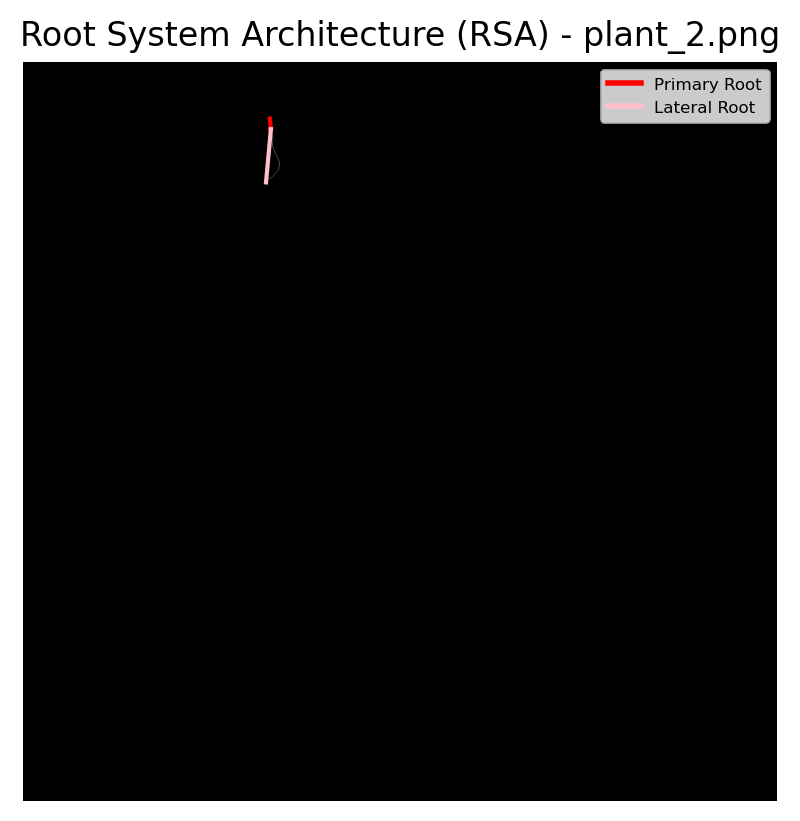

plant_2.png: Primary root length = 44.49 pixels
Primary root path: [0, 42, 39]

Skipping file (no components found): plant_3.png
Primary root for plant_4.png identified by MAX BRANCH COUNT (33 branches).


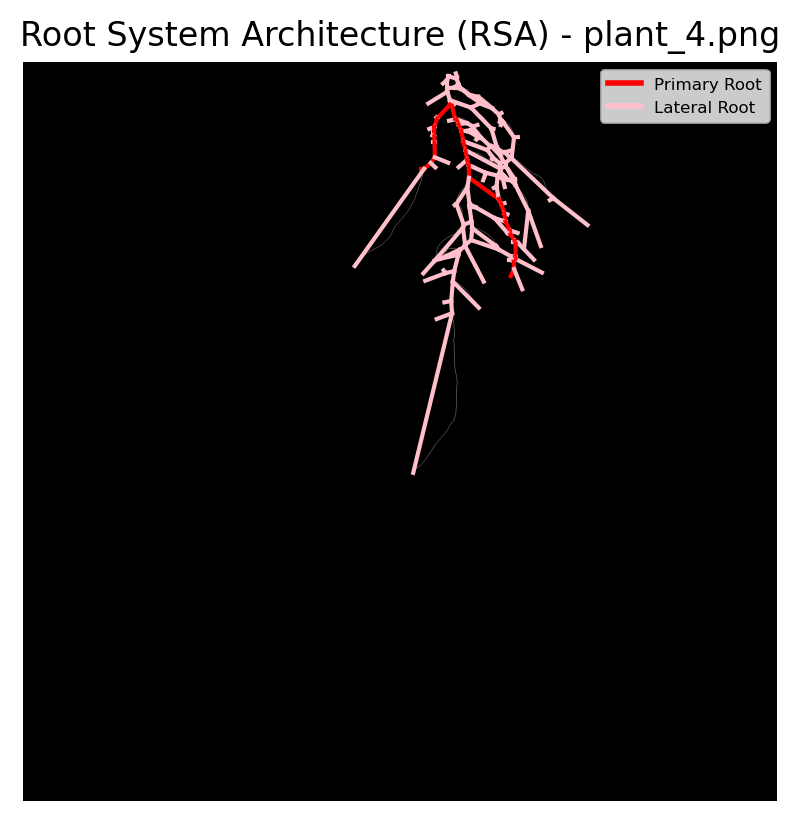

plant_4.png: Primary root length = 1062.06 pixels
Primary root path: [2787, 2790, 2544, 2273, 1737, 1560, 1386, 1265, 954, 634, 688, 992, 996, 1183, 1395, 1691, 1999, 2371, 2623, 3141, 3844, 3979, 4310, 4620, 4938, 4985, 5121, 5347, 5396, 5501, 6116, 6198, 6312, 6478, 6713]

Primary root for plant_5.png identified by MAX BRANCH COUNT (37 branches).


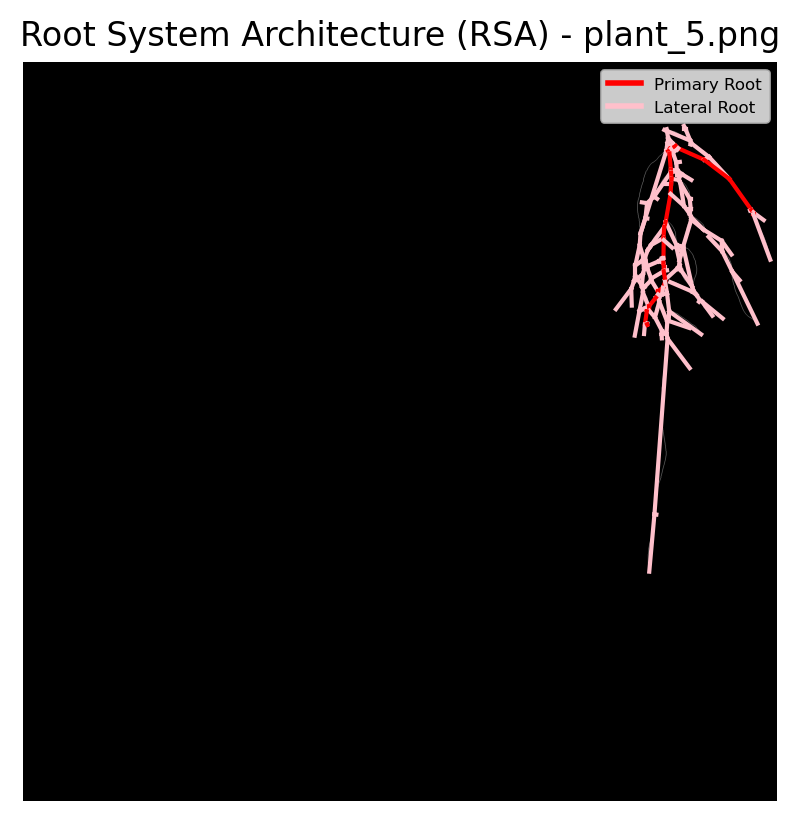

plant_5.png: Primary root length = 1182.56 pixels
Primary root path: [2188, 2185, 2136, 2076, 1239, 704, 368, 312, 385, 381, 453, 510, 919, 1010, 1012, 1230, 1399, 1617, 2401, 2564, 2928, 3005, 3798, 4014, 4161, 4329, 4348, 4714, 4806, 5072, 5238, 5362, 5507, 5838, 6028, 6056, 6547, 6555, 6572]



In [18]:
# Input and output directories
input_dir = r"C:\BUAS\retake\2024-25b-fai2-adsai-dariavladutu236578\datalab_tasks\task6\components"
output_dir = r"C:\BUAS\retake\2024-25b-fai2-adsai-dariavladutu236578\datalab_tasks\task7\RSA_output_2"
os.makedirs(output_dir, exist_ok=True)

# Loop through all PNG mask images
for filename in os.listdir(input_dir):
    if not filename.lower().endswith('.png'):
        continue

    mask_path = os.path.join(input_dir, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Skipping file (not readable): {filename}")
        continue

    try:
        # --- (Steps 1-3: Loading, Skeletonization, Graph Creation) ---
        # These steps remain the same as your original code.
        binary_mask = (mask > 0).astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
        if stats.shape[0] < 2:
            print(f"Skipping file (no components found): {filename}")
            continue
        largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
        component_mask = (labels == largest_component).astype(np.uint8)
        skeleton = skeletonize(component_mask)
        g0, c0 = skeleton_to_csgraph(skeleton)
        node_coordinates = np.transpose(c0)
        skeleton_obj = Skeleton(skeleton)
        branch_data = summarize(skeleton_obj)
        G = nx.from_pandas_edgelist(branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
        tip_nodes = [node for node, degree in G.degree() if degree == 1]

        # --- (Steps 4-6: MODIFIED Path Finding and Selection Logic) ---

        # Initialize candidates for both heuristics
        path_with_max_branches = []
        max_branch_count = -1

        path_with_max_length = []
        max_length = 0.0
        
        # 1. Iterate through all tip-to-tip paths to find the best candidates
        for tip in tip_nodes:
            lengths, paths = nx.single_source_dijkstra(G, tip, weight='branch-distance')
            for target, length in lengths.items():
                if target not in tip_nodes or tip == target:
                    continue  # Only consider paths between different tip nodes

                path = paths[target]
                if len(path) < 2:
                    continue

                # Heuristic 1: Count lateral branches
                # Sum of degrees of all nodes in the path
                total_degree = sum(G.degree[node] for node in path)
                # Each internal connection in the path is counted twice in the sum of degrees.
                # There are len(path) - 1 internal edges.
                internal_degree = 2 * (len(path) - 1)
                lateral_branch_count = total_degree - internal_degree

                if lateral_branch_count > max_branch_count:
                    max_branch_count = lateral_branch_count
                    path_with_max_branches = path

                # Heuristic 2: Find the longest path (this will be our fallback)
                if length > max_length:
                    max_length = length
                    path_with_max_length = path
        
        # 2. Final Selection Logic based on your proposed method
        # If any path has lateral branches, use that heuristic. Otherwise, fall back to the longest path.
        if max_branch_count > 0:
            longest_path = path_with_max_branches
            # We need to recalculate the length for the path chosen by branch count
            best_length = nx.path_weight(G, longest_path, weight='branch-distance')
            print(f"Primary root for {filename} identified by MAX BRANCH COUNT ({max_branch_count} branches).")
        else:
            longest_path = path_with_max_length
            best_length = max_length
            print(f"Primary root for {filename} identified by LONGEST PATH (no lateral branches found).")

        # --- (Step 7: Branch Classification) ---
        # This part is the same, but it now uses the 'longest_path' from the new logic.
        primary_root_edges = set(zip(longest_path[:-1], longest_path[1:]))
        branch_data['branch-type'] = branch_data.apply(
            lambda row: 1 if (row['node-id-src'], row['node-id-dst']) in primary_root_edges or
                             (row['node-id-dst'], row['node-id-src']) in primary_root_edges else 2,
            axis=1
        )

        # --- (Step 8: Visualization) ---
        # This part remains the same.
        branch_colors = {1: 'red', 2: 'pink'}
        fig, ax = plt.subplots()
        ax.imshow(skeleton, cmap='gray')

        for _, row in branch_data.iterrows():
            src = int(row['node-id-src'])
            dst = int(row['node-id-dst'])
            color = branch_colors[row['branch-type']]
            p1 = node_coordinates[src]
            p2 = node_coordinates[dst]
            ax.plot([p1[1], p2[1]], [p1[0], p2[0]], color=color, lw=1.5)

        legend_elements = [
            Line2D([0], [0], color='red', lw=2, label='Primary Root'),
            Line2D([0], [0], color='pink', lw=2, label='Lateral Root')
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=6, frameon=True)
        ax.set_title(f"Root System Architecture (RSA) - {filename}")
        ax.axis('off')
        fig.set_dpi(200)

        plt.show()

        output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_rsa.png")
        fig.savefig(output_path, bbox_inches='tight')
        plt.close(fig)

        print(f"{filename}: Primary root length = {best_length:.2f} pixels")
        print(f"Primary root path: {longest_path}\n")

    except Exception as e:
        print(f"Failed to process {filename}: {e}\n")

The first algorithm was too biased toward geometry, and the second version is too biased toward branching and length, making it vulnerable to well-developed lateral roots. The current hybrid score (`branches * length`) is a big improvement, but it fails because a long lateral root can still "outcompete" the true primary root if it's long enough and has enough of its own secondary branches.